# Wind Variability

In [16]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import io_utils as io
import vis_utils as vis
from utils import *
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [17]:
def construct_grid(vent, north, east, south, west, elevation, spacing):
    x_east = np.linspace(
        vent[0], vent[0] + (east * spacing), east + 1)
    x_west = np.linspace(
        vent[0] - west * spacing, vent[0], west + 1)
    x = np.concatenate((x_east[:-1], x_west))
    y_south = np.linspace(
        vent[1] - south * spacing, vent[1], south + 1)
    y_north = np.linspace(
        vent[1], vent[1] + north * spacing, north + 1)
    y = np.concatenate((y_south[:-1], y_north))

    xx, yy = np.meshgrid(x, y)

    cols = ['Easting', 'Northing', 'Elev.']

    zz = np.ones(xx.shape)*elevation

    df = pd.DataFrame(zz, index=y, columns=x)
    
    df = df.unstack().reset_index().rename(columns={'level_0':'Easting','level_1':'Northing',0:'Elev.'})

    return df


def write_grid_file(df, filename):
    df.to_csv(filename, sep=' ', columns=['Easting', 'Northing', 'Elev.'],
              index=False, header=False)
    
def plot_grid(df, vent=None, labels=None, save=None):
    xx = df['Easting'].values
    yy = df['Northing'].values

    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.plot(xx, yy, 'k.', ms=3)
    if vent is not None:
        ax.plot(vent.coords[0][0], vent.coords[0][1], 'r^', ms=6)
    if labels is None:
        plt.xlabel("Easting (m)")
        plt.ylabel("Northing (m)")
    else:
        plt.xlabel(labels[0])
        plt.ylabel(labels[0])
    if save is not None:
        plt.savefig(save, dpi=200, format='eps')
    return fig, ax

,Easting,Northing,Elev.
0,0,"-9,000",1
1,0,"-8,700",1
2,0,"-8,400",1
3,0,"-8,100",1
4,0,"-7,800",1
5,0,"-7,500",1
6,0,"-7,200",1
7,0,"-6,900",1
8,0,"-6,600",1
9,0,"-6,300",1


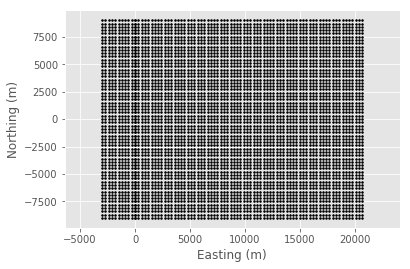

In [18]:
grid = construct_grid((0,0), 30, 70, 30, 10, 1, 300)
display(grid)
plot_grid(grid)
plt.show()
write_grid_file(grid, "reg_grid.txt")

In [19]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}
# Update parameters
# COL STEPS need to be small enough so the 
# layer height can be kept for an inversion with a high H
config["COL_STEPS"] = 50
theoretical_max = 45000 #The H value will be as close as possible to this
layer_thickness = ((config["PLUME_HEIGHT"]-config["VENT_ELEVATION"])/config["COL_STEPS"])

inversion_steps = np.round((config["COL_STEPS"]*(theoretical_max - config["VENT_ELEVATION"]))/\
                  (config["PLUME_HEIGHT"]-config["VENT_ELEVATION"]))
closest_H = ((inversion_steps*(config["PLUME_HEIGHT"] - config["VENT_ELEVATION"]))/\
             config["COL_STEPS"]) + config["VENT_ELEVATION"]
print("This number needs to be low enough to invert efficiently:")
print(inversion_steps)
print("If not, decrease COL_STEPS or theoretical max")
print("Closest Possible Theoretical Max Column Height:")
print(closest_H)

config["INV_STEPS"] = int(inversion_steps)
config["THEO_MAX_COL"] = closest_H
config["PART_STEPS"] = 9


config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

# To ensure monotonicity:
# config["DIFFUSION_COEFFICIENT"] = 1.7*config["FALL_TIME_THRESHOLD"]

print("INPUT PARAMETERS:")
display(config)
display(globs)

This number needs to be low enough to invert efficiently:
100.0
If not, decrease COL_STEPS or theoretical max
Closest Possible Theoretical Max Column Height:
44915.0
INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 50,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'INV_STEPS': 100,
 'THEO_MAX_COL': 44915.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

In [20]:
def gen_wind_file(x_bar, y_bar, x_sig, y_sig, heights, fname):
    #Open file
    f = open(fname, "w")
    levels = len(heights)

    #Generate wind vector
    x_levels = np.random.normal(x_bar, x_sig, levels)
    y_levels = np.random.normal(y_bar, y_sig, levels)

    #Convert to speed and azimuth
    directions = np.arctan2(y_levels, x_levels)
    degrees = (directions*180)/np.pi
    speeds = np.sqrt(x_levels**2 + x_levels**2)
    azimuths = 90 - degrees
    
    #Write to file
    windlines = [str(h) + " " + str(s) + " " + str(a) + "\n" for h,s,a in zip(heights, speeds, azimuths)]
    windfile = ''.join(windlines)
    f.write(windfile)
    f.close()
    
    return x_levels, y_levels, directions, degrees, speeds, azimuths

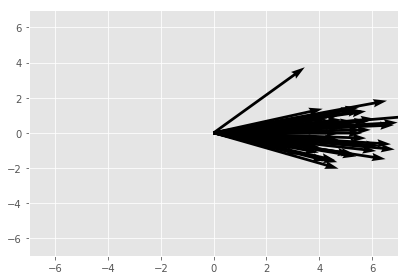

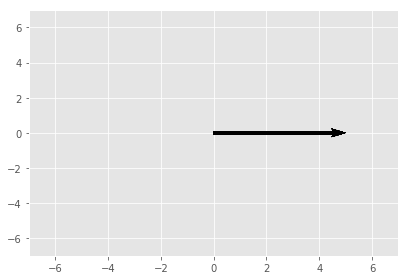

In [21]:
z = np.linspace(config["VENT_ELEVATION"] + layer_thickness, config["THEO_MAX_COL"], 
                config["COL_STEPS"])

x_wind_rand, y_wind_rand, directions_rand, degrees_rand, speeds_rand, azimuths_rand = gen_wind_file(5, 0, 1, 1, z, "rand_wind_file.txt")

x_wind_const, y_wind_const, directions_const, degrees_const, speeds_const, azimuths_const = gen_wind_file(5, 0, 0, 0, z, "const_wind_file.txt")


# wind_angle = np.radians(55)
# u = config["WIND_SPEED"]*np.cos(wind_angle)
# v = config["WIND_SPEED"]*np.sin(wind_angle)

plt.quiver(0,0, x_wind_rand, y_wind_rand, 
       angles='xy', scale_units='xy', scale=1)
plt.tight_layout()
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.show()

plt.quiver(0,0, x_wind_const, y_wind_const, 
       angles='xy', scale_units='xy', scale=1)
plt.tight_layout()
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.show()

In [22]:
def gaussian_stack_single_phi_multi_wind(
    grid, column_steps, z_min, z_max,
    beta_params, tot_mass, wind, phi, particle_density, elevation, 
    diffusion_coefficient, eddy_constant, fall_time_threshold
):
    global  AIR_DENSITY, GRAVITY, AIR_VISCOSITY

    wind_u, wind_v = wind

    
    # Release points in column
    layer_thickness = ((z_max-z_min)/column_steps)
    z = np.linspace(z_min + layer_thickness, z_max, column_steps)

    height_above_vent = z - z_min

    # TODO: This should be generalized to take point elevation into
    # account
    distance_below_vent = z_min - elevation

    
    plume_diffusion_fine_particle = [column_spread_fine(ht) for ht in height_above_vent]
    plume_diffusion_coarse_particle = [column_spread_coarse(ht, diffusion_coefficient) for ht in height_above_vent]

    d = phi2d(phi)/1000

    if distance_below_vent > 0:
        fall_time_adj = part_fall_time(
                z_min, distance_below_vent, 
                d, particle_density,
                AIR_DENSITY, 
                GRAVITY, 
                AIR_VISCOSITY
            )[0]
    else:
        fall_time_adj = 0.

    fall_values = [part_fall_time(
        zk, 
        layer_thickness,                   
        d, particle_density, 
        AIR_DENSITY, 
        GRAVITY, 
        AIR_VISCOSITY
    ) for zk in z]


    vv = [-e[1] for e in fall_values]
    ft = [e[0] for e in fall_values]
    
    #Mass distribution in the plume
    alpha, beta = beta_params
    
    # q_mass = mass_dist_in_plume(alpha, beta, z_min, z_max, z, tot_mass)
    q_mass = beta_plume(alpha, beta, z_max, tot_mass, z, z_min, z_max)

    xx = grid["Easting"].values
    yy = grid["Northing"].values
    dep_mass = np.zeros(xx.shape)
    

    wind_sum_x = 0
    wind_sum_y = 0

    sig = []
    wind_speed_list = []
    wind_angle_list = []
    wind_sum_x_list = []
    wind_sum_y_list = []
    total_fall_time_list = []
    x_adj_list = []
    y_adj_list = []

    # For each vertical height in the column
    for k, zh in enumerate(z):
        u = wind_u[k]
        v = wind_v[k]
        wind_angle = np.arctan2(v, u)
        wind_speed = np.sqrt(u**2 + v**2)
        windspeed_adj = (wind_speed*elevation)/z_min
        u_wind_adj = np.cos(wind_angle)*windspeed_adj
        v_wind_adj = np.sin(wind_angle)*windspeed_adj

        # Adjust the total fall time by the time it 
        # takes to fall below the vent height to the ground.

        total_fall_time = sum(ft[:k+1]) + fall_time_adj

        #Here we will put a proper wind field (u[k], v[k])
        x_adj = u_wind_adj*fall_time_adj
        y_adj = v_wind_adj*fall_time_adj

        wind_sum_x += ft[k]*u
        wind_sum_y += ft[k]*v

        average_windspeed_x = (wind_sum_x + x_adj)/total_fall_time
        average_windspeed_y = (wind_sum_y + y_adj)/total_fall_time

        # converting back to degrees
        average_wind_direction = np.arctan2(average_windspeed_y, average_windspeed_x)

        average_windspeed = np.sqrt(average_windspeed_x**2 + \
            average_windspeed_y**2)

        s_sqr = sigma_squared(
            zh, total_fall_time, 
            diffusion_coefficient,
            plume_diffusion_coarse_particle[k],
            plume_diffusion_fine_particle[k],
            eddy_constant, 
            fall_time_threshold
        )
        dist = strat_average(
            average_wind_direction, 
            average_windspeed, 
            xx, yy, 
            total_fall_time, s_sqr)
        
        dep_mass += (q_mass[k]/(s_sqr*np.pi))*dist

        sig.append(s_sqr)
        total_fall_time_list.append(total_fall_time)
        x_adj_list.append(x_adj)
        y_adj_list.append(y_adj)
        wind_sum_x_list.append(wind_sum_x)
        wind_sum_y_list.append(wind_sum_y)
        wind_speed_list.append(average_windspeed)
        wind_angle_list.append(average_wind_direction)

    dep_df = construct_dataframe(dep_mass, xx, yy)

    input_data = np.asarray([
        z, 
        np.asarray(q_mass),
        [d]*len(z),
        [particle_density]*len(z),
        wind_u,
        wind_v,
        ft,
        total_fall_time_list,
        [fall_time_adj]*len(z),
        x_adj_list,
        y_adj_list,
        vv,
        plume_diffusion_coarse_particle,
        plume_diffusion_fine_particle,
        sig,
        wind_angle_list, 
        wind_speed_list,
        wind_sum_x_list, 
        wind_sum_y_list,
        [windspeed_adj]*len(z),
        [u_wind_adj]*len(z),
        [v_wind_adj]*len(z)
    ]).T
    input_table = pd.DataFrame(
        input_data,  
        columns=[
            "Release Height (z)", 
            "Suspended Mass (q)",
            "Ash Diameter",
            "Particle Density",
            "Wind u",
            "Wind v",
            "Fall Time",
            "Total Fall Time",
            "Fall Time Adj",
            "X Adj",
            "Y Adj",
            "Terminal Velocity",
            "Col Spead Coarse",
            "Col Spead Fine",
            "Sigma",
            "Avg. Wind Angle",
            "Avg. Wind Speed",
            "Wind Sum x",
            "Wind Sum y",
            "Windspeed Adj",
            "U wind adj",
            "V wind adj"
        ])

    return input_table, dep_df, sig, vv, ft

In [23]:
input_table_rand, dep_df_rand, sig_rand, vv_rand, ft_rand = gaussian_stack_single_phi_multi_wind(grid = grid, 
                          column_steps = config["COL_STEPS"], 
                          z_min = config["VENT_ELEVATION"], 
                          z_max = config["THEO_MAX_COL"], 
                          beta_params = (config["ALPHA"], config["BETA"]),
                          tot_mass = config["ERUPTION_MASS"]/4,
                          wind = (x_wind_rand, y_wind_rand),
                          phi = 0,
                          particle_density = 1233.5,
                          elevation = 2500, 
                          diffusion_coefficient = config["DIFFUSION_COEFFICIENT"],
                          eddy_constant = config["EDDY_CONST"],
                          fall_time_threshold = config["FALL_TIME_THRESHOLD"]
                        )

input_table_const, dep_df_const, sig_const, vv_const, ft_const = gaussian_stack_single_phi_multi_wind(grid = grid, 
                          column_steps = config["COL_STEPS"], 
                          z_min = config["VENT_ELEVATION"], 
                          z_max = config["THEO_MAX_COL"], 
                          beta_params = (config["ALPHA"], config["BETA"]),
                          tot_mass = config["ERUPTION_MASS"]/4,
                          wind = (x_wind_const, y_wind_const),
                          phi = 0,
                          particle_density = 1233.5,
                          elevation = 2500, 
                          diffusion_coefficient = config["DIFFUSION_COEFFICIENT"],
                          eddy_constant = config["EDDY_CONST"],
                          fall_time_threshold = config["FALL_TIME_THRESHOLD"]
                        )

display(input_table_rand)
display(input_table_const)

,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Wind u,Wind v,Fall Time,Total Fall Time,Fall Time Adj,X Adj,...,Col Spead Coarse,Col Spead Fine,Sigma,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,"3,921.6",4.16334e+08,0.001,"1,233.5",4.34778,-0.411791,148.937,256.684,107.748,379.631,...,0.557689,114.4,4.13234e+06,-0.0944313,4.01961,647.544,-61.3308,3.40411,3.39585,0.237053
1,"4,758.2",4.15834e+08,0.001,"1,233.5",2.96541,-0.876507,143.957,400.641,107.748,258.928,...,2.23076,199.182,6.47173e+06,-0.195499,3.3927,"1,074.43",-187.51,3.40411,3.39585,0.237053
2,"5,594.8",4.13711e+08,0.001,"1,233.5",4.65904,0.590842,139.143,539.784,107.748,406.808,...,5.0192,275.501,8.75172e+06,-0.0252155,3.94638,"1,722.71",-105.298,3.40411,3.39585,0.237053
3,"6,431.4",4.10776e+08,0.001,"1,233.5",4.68905,-1.66834,134.491,674.275,107.748,409.429,...,8.92302,346.796,1.09749e+07,-0.170386,4.1576,"2,353.34",-329.675,3.40411,3.39585,0.237053
4,"7,268",4.07332e+08,0.001,"1,233.5",4.32017,0.809003,129.994,804.269,107.748,377.22,...,13.9422,414.574,1.31437e+07,-0.0467044,4.09782,"2,914.94",-224.509,3.40411,3.39585,0.237053
5,"8,104.6",4.0353e+08,0.001,"1,233.5",6.83479,0.444544,125.647,929.916,107.748,596.786,...,20.0768,479.675,1.52607e+07,-0.029699,4.70196,"3,773.71",-168.653,3.40411,3.39585,0.237053
6,"8,941.2",3.99452e+08,0.001,"1,233.5",4.62141,-1.57075,121.446,"1,051.36",107.748,403.523,...,27.3268,542.631,1.73281e+07,-0.104413,4.53168,"4,334.96",-359.415,3.40411,3.39585,0.237053
7,"9,777.8",3.9515e+08,0.001,"1,233.5",4.82516,-0.466252,117.385,"1,168.75",107.748,421.313,...,35.6921,603.807,1.93481e+07,-0.0852493,4.57077,"4,901.37",-414.146,3.40411,3.39585,0.237053
8,"10,614.4",3.90658e+08,0.001,"1,233.5",3.45361,3.73474,113.461,"1,282.21",107.748,301.555,...,45.1728,663.468,2.13231e+07,0.059931,4.37123,"5,293.22",9.5997,3.40411,3.39585,0.237053
9,"11,451",3.86e+08,0.001,"1,233.5",5.62398,0.357619,109.667,"1,391.88",107.748,491.063,...,55.7689,721.816,2.3255e+07,0.0125043,4.59922,"5,909.98",48.8186,3.40411,3.39585,0.237053


,Release Height (z),Suspended Mass (q),Ash Diameter,Particle Density,Wind u,Wind v,Fall Time,Total Fall Time,Fall Time Adj,X Adj,...,Col Spead Coarse,Col Spead Fine,Sigma,Avg. Wind Angle,Avg. Wind Speed,Wind Sum x,Wind Sum y,Windspeed Adj,U wind adj,V wind adj
0,"3,921.6",4.16334e+08,0.001,"1,233.5",5,0,148.937,256.684,107.748,436.58,...,0.557689,114.4,4.13234e+06,0,4.602,744.683,0,4.05186,4.05186,0
1,"4,758.2",4.15834e+08,0.001,"1,233.5",5,0,143.957,400.641,107.748,436.58,...,2.23076,199.182,6.47173e+06,0,4.74501,"1,464.47",0,4.05186,4.05186,0
2,"5,594.8",4.13711e+08,0.001,"1,233.5",5,0,139.143,539.784,107.748,436.58,...,5.0192,275.501,8.75172e+06,0,4.81074,"2,160.18",0,4.05186,4.05186,0
3,"6,431.4",4.10776e+08,0.001,"1,233.5",5,0,134.491,674.275,107.748,436.58,...,8.92302,346.796,1.09749e+07,0,4.84849,"2,832.64",0,4.05186,4.05186,0
4,"7,268",4.07332e+08,0.001,"1,233.5",5,0,129.994,804.269,107.748,436.58,...,13.9422,414.574,1.31437e+07,0,4.87298,"3,482.61",0,4.05186,4.05186,0
5,"8,104.6",4.0353e+08,0.001,"1,233.5",5,0,125.647,929.916,107.748,436.58,...,20.0768,479.675,1.52607e+07,0,4.89014,"4,110.84",0,4.05186,4.05186,0
6,"8,941.2",3.99452e+08,0.001,"1,233.5",5,0,121.446,"1,051.36",107.748,436.58,...,27.3268,542.631,1.73281e+07,0,4.90283,"4,718.07",0,4.05186,4.05186,0
7,"9,777.8",3.9515e+08,0.001,"1,233.5",5,0,117.385,"1,168.75",107.748,436.58,...,35.6921,603.807,1.93481e+07,0,4.91259,"5,305",0,4.05186,4.05186,0
8,"10,614.4",3.90658e+08,0.001,"1,233.5",5,0,113.461,"1,282.21",107.748,436.58,...,45.1728,663.468,2.13231e+07,0,4.92033,"5,872.3",0,4.05186,4.05186,0
9,"11,451",3.86e+08,0.001,"1,233.5",5,0,109.667,"1,391.88",107.748,436.58,...,55.7689,721.816,2.3255e+07,0,4.9266,"6,420.64",0,4.05186,4.05186,0


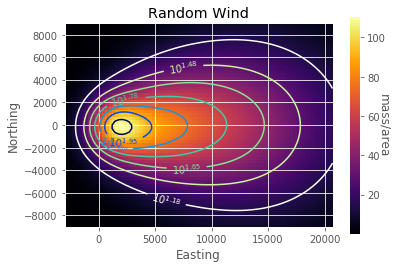

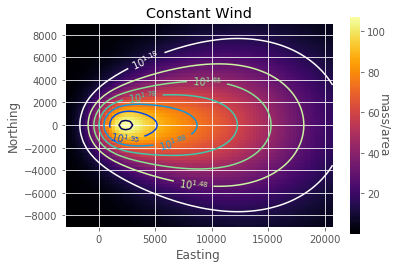

In [24]:
vis.plot_contour(dep_df_rand, log=False, line_cmap="negative", cbar_label="mass/area", title="Random Wind")
vis.plot_contour(dep_df_const, log=False, line_cmap="negative", cbar_label="mass/area", title="Constant Wind")



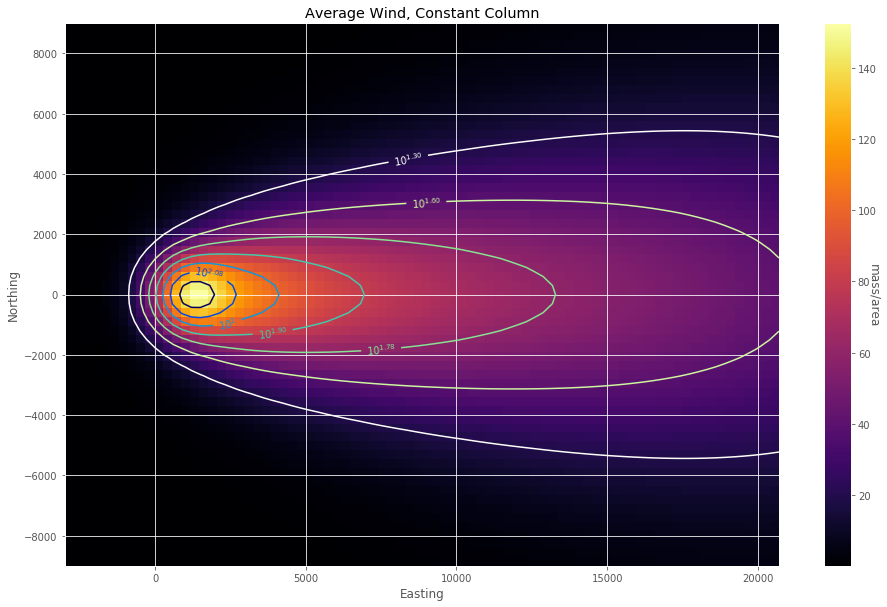

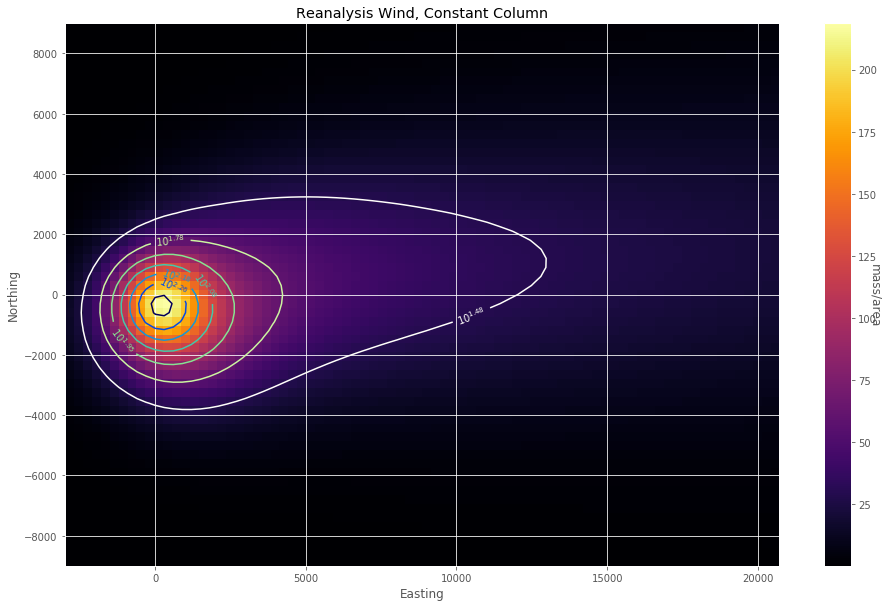

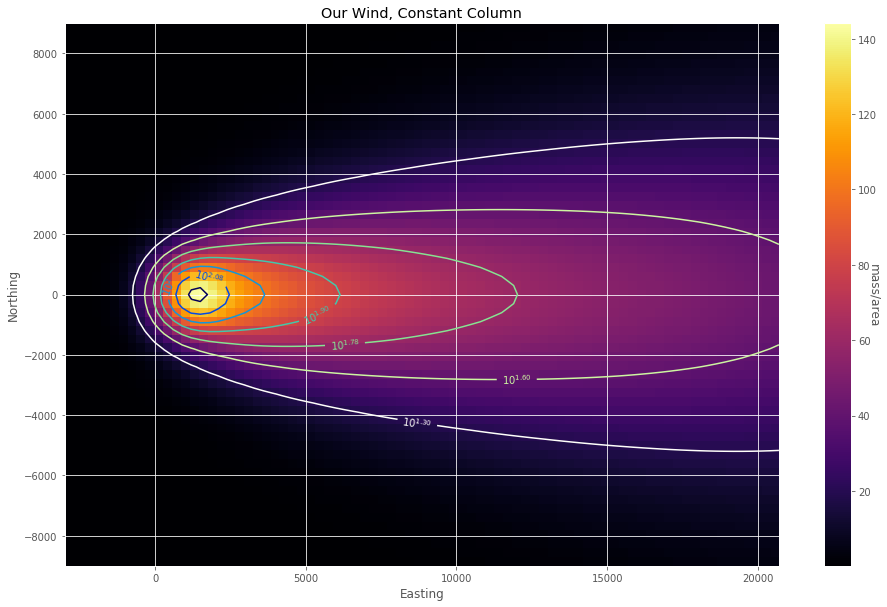

In [50]:
t2_avg_wind, _, _, _ = io.read_tephra2("data/colima/average_wind_connor_col_out.txt")
t2_connor_wind, _, _, _ = io.read_tephra2("data/colima/connor_wind_connor_col_out.txt")
t2_our_wind, _, _, _ = io.read_tephra2("data/colima/our_wind_connor_col_out.txt")

# display(t2_rand_wind.head())
plt.rcParams["figure.figsize"] = (16, 10)
vis.plot_contour(t2_avg_wind, log=False, line_cmap="negative", cbar_label="mass/area", title="Average Wind, Constant Column")
vis.plot_contour(t2_connor_wind, log=False, line_cmap="negative", cbar_label="mass/area", title="Reanalysis Wind, Constant Column")
vis.plot_contour(t2_our_wind, log=False, line_cmap="negative", cbar_label="mass/area", title="Our Wind, Constant Column")

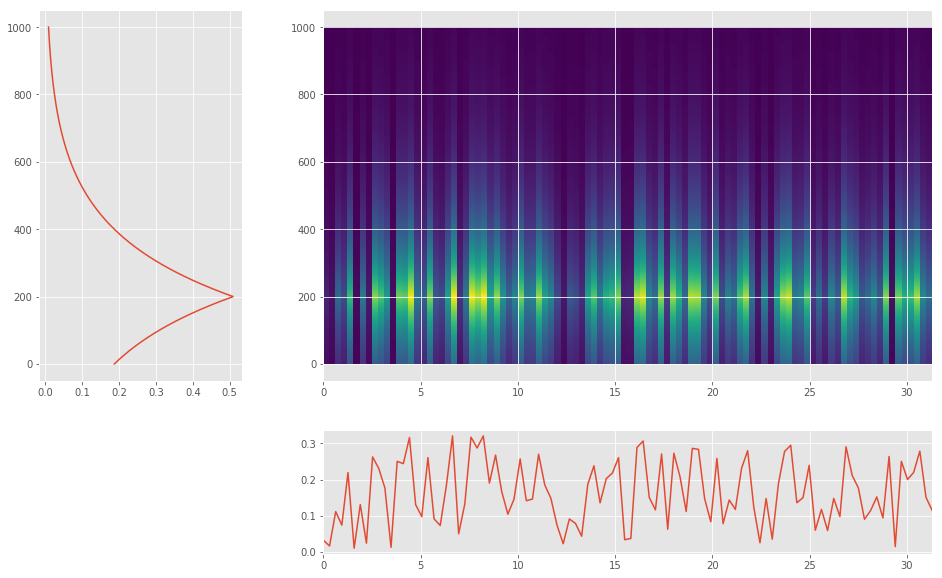

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

t = np.linspace(0, 31.3, 100)
f = np.linspace(0, 1000, 1000)
a = np.exp(-np.abs(f-200)/200)[:, None] * np.random.rand(t.size)
flim = (f.min(), f.max())
tlim = (t.min(), t.max())

gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey=ax)
axb = plt.subplot(gs[1,1], sharex=ax)

ax.imshow(a, origin='lower', extent=tlim+flim, aspect='auto')
plt.xlim(tlim)

axl.plot(a.mean(1), f)
axb.plot(t, a.mean(0))

plt.show()

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_contour_marginals(
    df, vent=False, ax=None, 
    values="MassArea", title="Isomass Plot", 
    cmap='inferno', log=True, lines=True, 
    line_cmap=None, line_colors=None, 
    background="gradient", cbar_label=None, 
    save=None, levels=None,
    marginals=None):

    # TODO: Figure out why low phi deposits break both the negative/grayscale linemaps, and the filled contours.  

    df = df[df[values]>0]

    piv = pd.pivot_table(df, index="Northing",
                         columns="Easting", values=values)

    if log:
        norm = LogNorm(vmin=piv.values.min(), vmax=piv.values.max())
    else:
        norm = None

    if ax is None:
        if marginals is None:
            fig, ax = plt.subplots(1, 1)
        else:
            gs = gridspec.GridSpec(2, 3, width_ratios=[2,5,1], height_ratios=[3,1])
            fig = plt.gcf()
            ax = plt.subplot(gs[0,1])
            axl = plt.subplot(gs[0,0], sharey=ax)
            axb = plt.subplot(gs[1,1], sharex=ax)
            axl.set_ylabel("Northing")
            axb.set_xlabel("Easting")
            for tic in ax.xaxis.get_major_ticks():
                tic.tick1On = tic.tick2On = False
                tic.label1On = tic.label2On = False
                
            for tic in ax.yaxis.get_major_ticks():
                tic.tick1On = tic.tick2On = False
                tic.label1On = tic.label2On = False
    else:
        fig = plt.gcf()
        ax.set_ylabel("Northing")
        ax.set_xlabel("Easting")
    # ax.axis('equal')

    ax.set_title(title)

    if background == "gradient":
        if log:
            vals = np.log10(piv.values)
        else:
            vals = piv.values
        bg = ax.imshow(vals,
                       extent=[piv.columns.min(), piv.columns.max(),
                               piv.index.min(), piv.index.max()],
                       origin='lower',
                       cmap=cmap, alpha=1)

    elif background == "fill":
        if levels:
            bg = ax.contourf(piv.columns, piv.index, piv.values, levels=levels,
                         cmap=cmap, vmin=piv.values.min(), vmax=piv.values.max())
        else:
            bg = ax.contourf(piv.columns, piv.index, piv.values, levels=levels,
                         cmap=cmap, vmin=piv.values.min(), vmax=piv.values.max())
            print(bg.levels)

    if lines:
        if line_cmap == "grayscale":
            colormap = cm.get_cmap(cmap, 256)
            oldcolors = colormap(np.linspace(0, 1, 256))
            newcolors = []
            for i, col in enumerate(oldcolors):
                r, g, b = [(1-col[j]) for j in range(3)]
                luminosity = 0.21*r + 0.72*g + 0.07*b
                newcolors.append([luminosity, luminosity, luminosity, 1])
            newcmp = ListedColormap(np.array(newcolors))
            lns = ax.contour(piv.columns, piv.index, piv.values, norm=norm,levels=levels,
                             cmap=newcmp)
        elif line_cmap == "negative":
            colormap = cm.get_cmap(cmap, 256)
            oldcolors = colormap(np.linspace(0, 1, 256))
            newcolors = [[(1-col[j]) for j in range(3)] + [1] for col in oldcolors]
            newcmp = ListedColormap(np.array(newcolors))
            lns = ax.contour(piv.columns, piv.index, piv.values, norm=norm,levels=levels,
                             cmap=newcmp)
        elif line_cmap is not None:
            lns = ax.contour(piv.columns, piv.index, piv.values, norm=norm,levels=levels,
                             cmap=line_cmap)
        elif line_colors is not None:
            lns = ax.contour(piv.columns, piv.index, piv.values, norm=norm,levels=levels,
                             colors=line_colors)
        else:
            lns = ax.contour(piv.columns, piv.index, piv.values, norm=norm,levels=levels,
                             colors='k')
        fmt = ticker.LogFormatterMathtext()
        fmt.create_dummy_axis()
        ax.clabel(lns, lns.levels, fmt=fmt, fontsize=10)

    if marginals is not None:
        east_intercept = df[df["Easting"]==marginals[0]].sort_values(by="Northing")
        north_intercept = df[df["Northing"]==marginals[1]].sort_values(by="Easting")
        axl.plot(east_intercept["MassArea"], east_intercept["Northing"], color="C0")
        axb.plot(north_intercept["Easting"], north_intercept["MassArea"], color="C1")
        ax.vlines(x=marginals[0], ymin=piv.index.min(), ymax=piv.index.max(), colors=["C0"], linewidth=3, )
        ax.hlines(y=marginals[1], xmin=piv.columns.min(), xmax=piv.columns.max(), colors=["C1"], linewidth=3,)
        axl.set_xlim((0, 150))
        axb.set_ylim((0, 220))

    if vent:
        ax.plot(vent[0], vent[1], 'r^', ms=10, markeredgecolor="w")

    ax.set_xlim(right=piv.columns.max(), left=piv.columns.min())
    ax.set_ylim(bottom=piv.index.min(), top=piv.index.max())
    ax.set_aspect("equal")

    return fig, ax

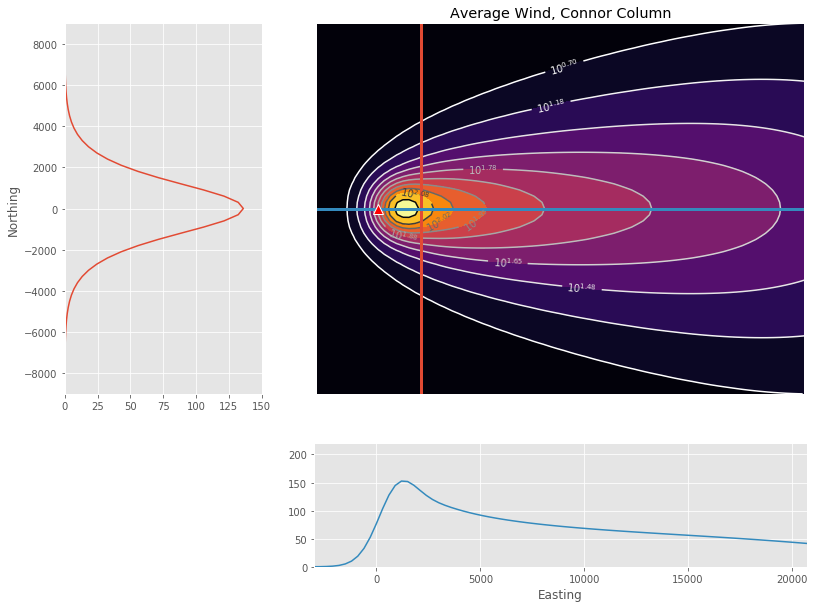

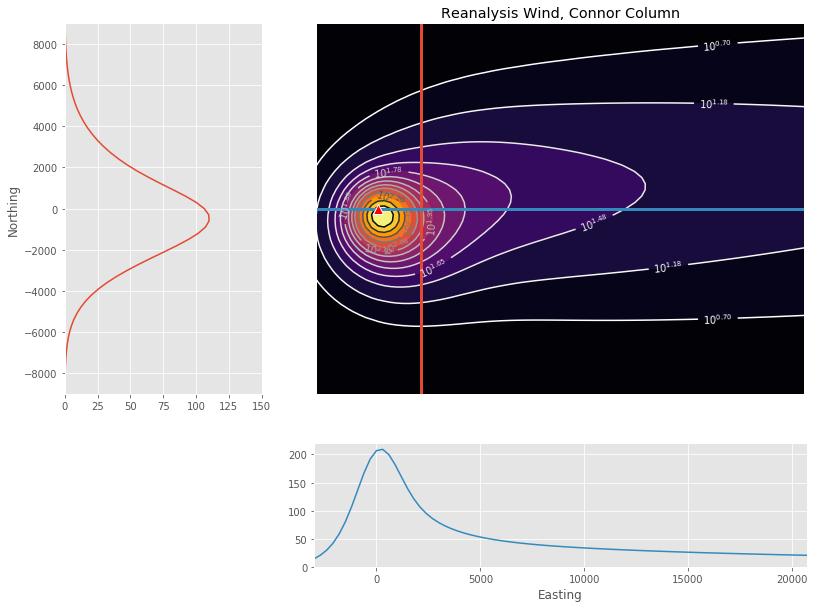

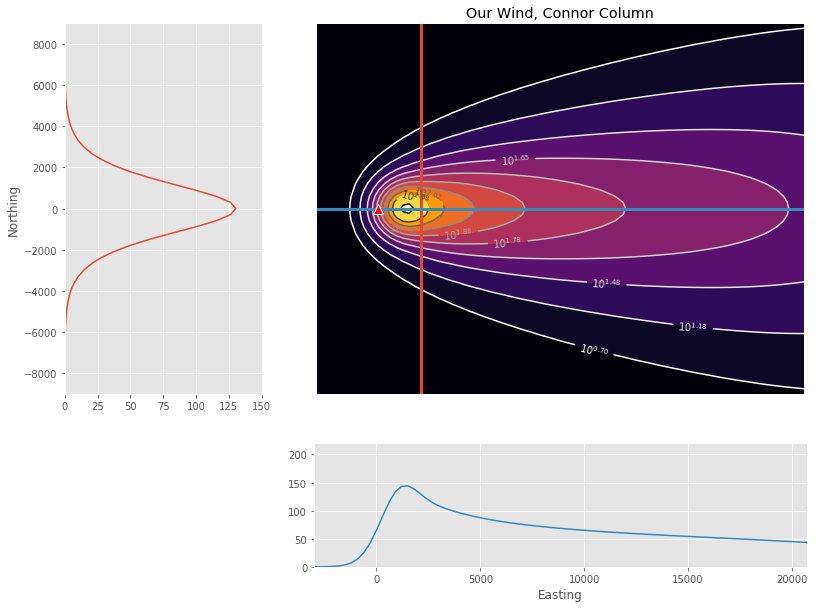

In [59]:
# gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
# ax = plt.subplot(gs[0,1])
# axl = plt.subplot(gs[0,0], sharey=ax)
# axb = plt.subplot(gs[1,1], sharex=ax)
plt.rcParams["figure.figsize"] = (16, 10)

levels=[0., 5.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 140., 160., 180., 200., 220.]

# levels=None
fig, ax = plot_contour_marginals(t2_avg_wind, 
                 log=False, 
                 line_cmap="grayscale", 
                 cbar_label="mass/area", 
                 title="Average Wind, Connor Column",
                 background="fill",
                 marginals=(2100,0), 
                 vent=(0,0),
                 levels=levels)
# plt.tight_layout()



plt.show()

fig, ax = plot_contour_marginals(t2_connor_wind, 
                 log=False, 
                 line_cmap="grayscale", 
                 cbar_label="mass/area", 
                 title="Reanalysis Wind, Connor Column",
                 background="fill",
                 marginals=(2100,0), levels=levels,
                 vent=(0,0))
# plt.tight_layout()

plt.show()

fig, ax = plot_contour_marginals(t2_our_wind, 
                 log=False, 
                 line_cmap="grayscale", 
                 cbar_label="mass/area", 
                 title="Our Wind, Connor Column",
                 background="fill",
                 marginals=(2100,0),  levels=levels,
                 vent=(0,0))
# plt.tight_layout()

plt.show()

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'zdir'
  s)


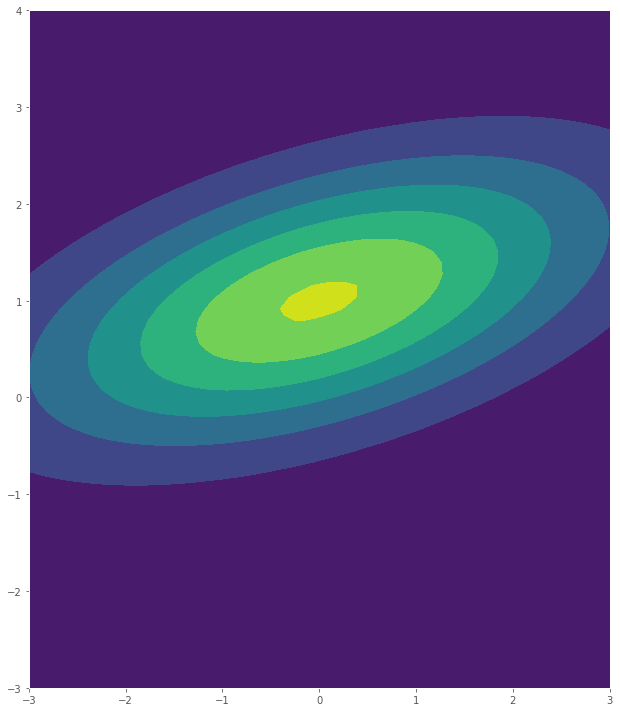

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

rho = 0.5
sigma_x = 2
sigma_y = 1

# Mean vector and covariance matrix
mu = np.array([0, 1.])
Sigma = np.array([[sigma_x**2 , rho*sigma_x*sigma_y], 
                  [rho*sigma_x*sigma_y,  sigma_y**2]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca()
# ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
#                 cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', cmap=cm.viridis)

# Adjust the limits, ticks and view angle
# ax.set_zlim(-0.15,0.2)
# ax.set_zticks(np.linspace(0,0.2,5))
# ax.view_init(-90,0)
ax.set_aspect('equal', "box")
plt.tight_layout()
plt.show()


In [35]:
def read_wind_file(filename):
    df = pd.read_csv(filename, sep="\t", names=["HEIGHT", "SPEED", "DIRECTION"])
    return df
    
def marks_avg(p, wind):
    u_list = []
    v_list = []
    
    u_parts = []
    v_parts = []
    for k, row in wind.iterrows():
        angle = np.radians(90-row["DIRECTION"])
        u_wind = row["SPEED"]*np.cos(angle)
        v_wind = row["SPEED"]*np.sin(angle)
        u_list += [u_wind]
        v_list += [v_wind]
        
        u_star = np.sum(u_list)/(k+1)
        v_star = np.sum(v_list)/(k+1)
        print(u_wind, v_wind)
        u_parts += [p[k]*u_star]
        v_parts += [p[k]*v_star]

    print(u_list, v_list)
    print(len(wind))
    u_bar = np.sum(u_parts)
    v_bar = np.sum(v_parts)
    print(u_bar, v_bar)
    avg_speed = np.sqrt(u_bar**2 + v_bar **2)
    avg_dir = 90-np.degrees(np.arctan2(v_bar, u_bar))
    
    new_wind = wind
    
    new_wind["SPEED"] = [avg_speed]*len(new_wind)
    new_wind["DIRECTION"] = [avg_dir]*len(new_wind)
    
    
    return new_wind

    

In [76]:
wind = read_wind_file("data/colima/connor_wind.txt")

display(wind)

config["VENT_ELEVATION"] = 1
config["ALPHA"] = 1.02
config["BETA"] = 1.56
config["ERUPTION_MASS"] = 1


layer_thickness = ((config["PLUME_HEIGHT"]-config["VENT_ELEVATION"])/len(wind))
z = np.linspace(config["VENT_ELEVATION"] + layer_thickness, config["PLUME_HEIGHT"], 
                len(wind))
q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = beta_plume(config["ALPHA"],config["BETA"],config["PLUME_HEIGHT"],
                    config["ERUPTION_MASS"],
                    z,
                    config["VENT_ELEVATION"], 
                    config["PLUME_HEIGHT"])
display(q_mass)

sum(q_mass)


,HEIGHT,SPEED,DIRECTION
0,0,2.526,120
1,1000,2.526,120
2,2000,2.866,90
3,3000,6.36,10
4,4000,10.717,10
5,5000,12.653,40
6,6000,14.954,40
7,7000,16.496,40
8,8000,17.944,40
9,9000,19.517,40


array([0.05345183, 0.0529054 , 0.05213109, 0.05123445, 0.0502546 ,
       0.04921007, 0.04811071, 0.04696196, 0.04576669, 0.04452615,
       0.04324038, 0.0419085 , 0.04052877, 0.03909868, 0.03761483,
       0.03607289, 0.03446737, 0.03279135, 0.03103608, 0.02919028,
       0.02723918, 0.02516283, 0.0229333 , 0.0205093 , 0.0178251 ,
       0.01476315, 0.01106507, 0.        , 0.        ])

0.9999999999999999

In [37]:
wind_df = marks_avg(q_mass, wind)

wind_df.to_csv("data/colima/average_wind_connor_col.txt", sep=" ", header=False, index=False)

display(wind_df)

2.187580169959492 -1.2629999999999997
2.187580169959492 -1.2629999999999997
2.866 0.0
1.1044024099616776 6.263377309157644
1.8609875200564934 10.554184689031834
8.133191625363782 9.692760338784428
9.61224591525251 11.455428602401197
10.603424409389152 12.63666913369066
11.534180868215264 13.745901487326943
12.545285778252188 14.950889396353093
13.546106086534131 16.143620594289345
14.348305023422931 17.099644059301827
15.504679933249015 18.47775801247287
16.646270728052308 19.838252943452172
16.751687896040902 19.963884232123686
16.52028435655375 19.688108232600854
13.973844209808554 13.973844209808554
8.53194949072181 12.184886658798753
5.044371572136988 10.817689746069453
3.85512378359866 8.267339633348321
2.1367579313609766 4.582292171257302
1.5120000000000002 2.6188608210441418
2.7832703499427156 3.3169724387051747
4.54707955092258 5.41899839062365
4.54707955092258 5.41899839062365
4.54707955092258 5.41899839062365
4.54707955092258 5.41899839062365
4.54707955092258 5.41899839062365

,HEIGHT,SPEED,DIRECTION
0,0,9.11181,41.8532
1,1000,9.11181,41.8532
2,2000,9.11181,41.8532
3,3000,9.11181,41.8532
4,4000,9.11181,41.8532
5,5000,9.11181,41.8532
6,6000,9.11181,41.8532
7,7000,9.11181,41.8532
8,8000,9.11181,41.8532
9,9000,9.11181,41.8532


In [41]:
my_wind = wind.copy()

my_u = 5.75009
my_v = 8.2071

speed = np.sqrt(my_u**2 + my_v **2)
direction = 90-np.degrees(np.arctan2(my_v, my_u))

my_wind["SPEED"] = [speed]*len(my_wind)
my_wind["DIRECTION"] = [direction]*len(my_wind)

display(my_wind)

wind_df.to_csv("data/colima/our_wind_solution.txt", sep=" ", header=False, index=False)


,HEIGHT,SPEED,DIRECTION
0,0,10.021,35.016
1,1000,10.021,35.016
2,2000,10.021,35.016
3,3000,10.021,35.016
4,4000,10.021,35.016
5,5000,10.021,35.016
6,6000,10.021,35.016
7,7000,10.021,35.016
8,8000,10.021,35.016
9,9000,10.021,35.016


In [ ]:
avg_speed = np.sqrt(u_bar**2 + v_bar **2)
avg_dir = 90-np.degrees(np.arctan2(v_bar, u_bar))